In [40]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../neural_networks/mnist_cnn')
import mnistCnn
from skimage.color import gray2rgb, rgb2gray, label2rgb
!{sys.executable} -m pip install lime # install shap
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [41]:
# load model
cnn = mnistCnn.MnistCnn()
cnn.loadWeights('../neural_networks/mnist_cnn/m3_150Epochs')

In [42]:
# load dataset
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255
#print(test_data.shape)
y_test_one_hot = np.eye(10)[y_test]

In [43]:
np.random.seed(24)
indices = np.random.randint(0,test_data.shape[0],100)
background = test_data[indices]
index = np.random.randint(0,test_data.shape[0])
#print(index in indices)
test_image = test_data[index]
pred = np.argmax(tf.squeeze(cnn.model(np.expand_dims(test_image,0))).numpy())
print(test_image.shape)
print((test := gray2rgb(test_image[:,:,0])).shape)
print(background.shape)
print(rgb2gray(test).shape)
print(gray2rgb(background[:,:,:,0]).shape)

(28, 28, 1)
(28, 28, 3)
(100, 28, 28, 1)
(28, 28)
(100, 28, 28, 3)


In [44]:
def rgbModel(x):
    grayImages = rgb2gray(x)
    if(len(grayImages.shape) == 3):
        return cnn.model(np.expand_dims(grayImages, -1))
    else:
        return cnn.model(np.expand_dims(np.expand_dims(grayImages, -1), 0))

In [45]:
print(rgbModel(gray2rgb(test_image[:,:,0])))
#print(tf.argmax(rgbModel(gray2rgb(background[:,:,:,0]))))

tf.Tensor(
[[3.0189609e-13 1.0058977e-11 6.7414086e-13 4.9607363e-16 9.9999988e-01
  1.1644550e-13 7.0856980e-11 3.1883177e-13 1.9755007e-12 7.6263412e-08]], shape=(1, 10), dtype=float32)


In [46]:
explainer = lime_image.LimeImageExplainer(verbose = False)
#segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
#segmenter = SegmentationAlgorithm('slic', n_segments=784, compactness = 0.01, max_size_factor=1)
segmenter = SegmentationAlgorithm('felzenszwalb', scale=3, sigma=0.8, min_size=4)

In [47]:
explanation = explainer.explain_instance(gray2rgb(test_image[:,:,0]), classifier_fn = rgbModel, hide_color=0, num_samples=100, segmentation_fn = segmenter)

100%|██████████| 100/100 [00:00<00:00, 2884.17it/s]


[0 1]
[0 1 2]


Text(0.5, 1.0, 'Positive/Negative Regions for 4')

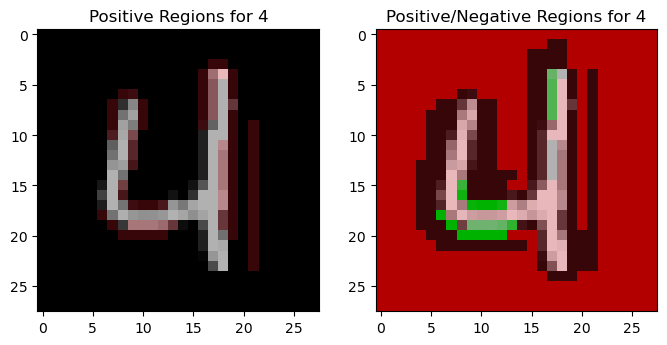

In [110]:
s = 1/255.0
colors2 = [[s*181,s*22,s*33],[0.0,0.0,0.0]]
colors3 = [[s*181,s*22,s*33],[0.0,0.0,0.0],[s*0,s*100,s*173]]

temp, mask = explanation.get_image_and_mask(9, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.001)
print(np.unique(mask))
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, colors=colors2, bg_label = 0, saturation = 1.0), interpolation = 'none')
ax1.set_title('Positive Regions for {}'.format(y_test[index]))
temp, mask = explanation.get_image_and_mask(9, positive_only=False, num_features=10, hide_rest=False, min_weight = 0.001)
print(np.unique(1+mask))
ax2.imshow(label2rgb(1+mask,temp, colors=colors3, bg_label = 0, saturation=1.0), interpolation = 'none')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[index]))

0.0


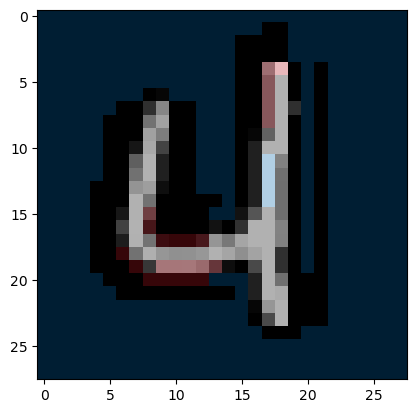

In [116]:
test_img2d = test_image[:,:,0]
tempImg = np.zeros((28,28))
maskedTempImg = label2rgb(3-mask, test_img2d, colors=colors3, bg_label=0, saturation = 0)
maskImg = mask/2 + 1
f = 0.2
blendImg = f*test_img2d + (1-f)*maskImg
print(np.min(maskedTempImg))
plt.imshow(maskedTempImg, interpolation = 'none')

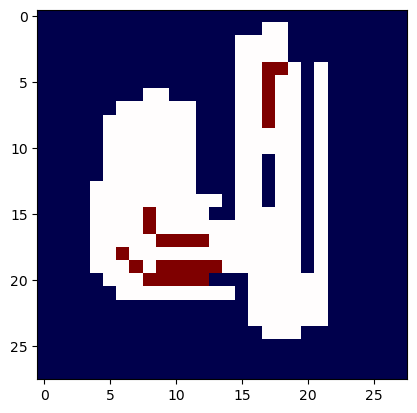

In [104]:
plt.imshow(maskImg, interpolation = 'none', cmap = 'seismic')

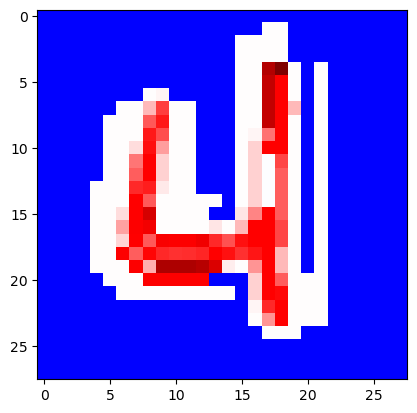

In [105]:
test_img2d = test_image[:,:,0]
blendV2 = 0.5*test_img2d + 0.5*mask
plt.imshow(blendV2, interpolation = 'none', cmap = 'seismic', vmin = -1, vmax = 1)